In [1]:
#imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import plotly.graph_objects as go

In [2]:
# load csv
df_college = pd.read_csv('college_data.csv')

# remove NaN
df_college = df_college.dropna() # only leaves 794 rows

In [3]:
# standardize x features
cols = [list(df_college.columns)[i] for i in range(len(list(df_college.columns))) if i not in [0, 5]]
df_standardized = df_college[cols] / df_college[cols].std()

In [4]:
# distribute the dataset into two components X and Y
cols = [list(df_college.columns)[i] for i in range(len(list(df_college.columns))) if i not in [0, 5]]
X = df_standardized[cols].to_numpy()
y = df_college['Retention Rate'].to_numpy()

## Feature Importance

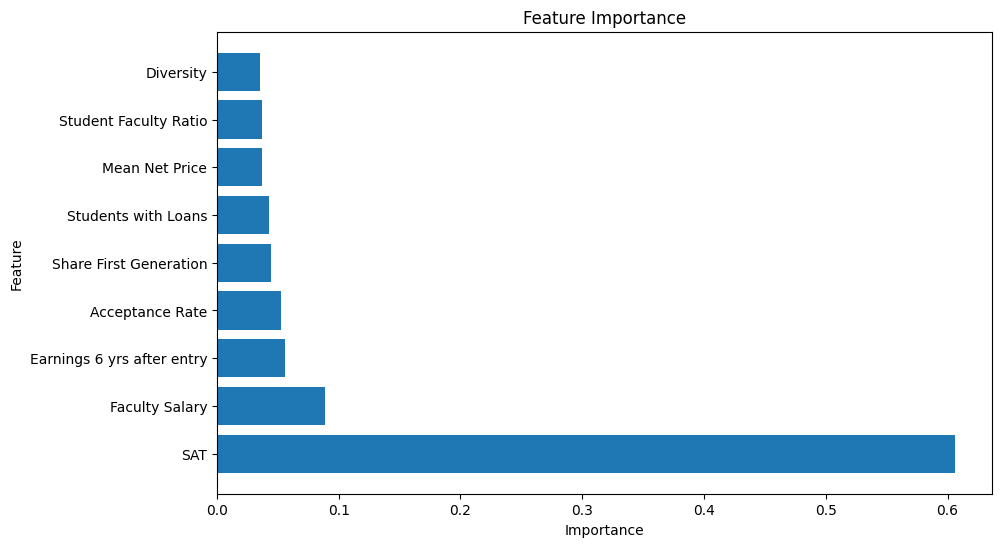

In [5]:
X = df_standardized 
y = df_college['Retention Rate'] 

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# fit the model on training data
rf_model.fit(X_train, y_train)

# get feature importances
feature_importances = rf_model.feature_importances_

# create a DataFrame to visualize feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [6]:
important_features = ['SAT', 'Faculty Salary', 'Earnings 6 yrs after entry', 'Acceptance Rate', 'Share First Generation', 'Students with Loans', 'Mean Net Price', 'Student Faculty Ratio', 'Diversity']

## Random Forest Regressor

In [7]:
def rfr(cols):
    """ fits a Random Forest Regressor model to given columns

    Arguments:
        cols (list): names of columns to be fed to RFR

    Returns:
        dictionary of relevant information of resulting RFR model
    """
    X = df_standardized[cols].to_numpy()
    y = df_college['Retention Rate'].to_numpy()

    # split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # create Random Forest Regressor model
    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

    # train model
    rf_regressor.fit(X_train, y_train)

    # make predictions on test set
    y_pred = rf_regressor.predict(X_test)

    # evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    residuals = y_test - y_pred

    return {'mse':mse, 'r2':r2, 'residuals':residuals, 'X_test':X_test, 'y_test':y_test, 'y_pred':y_pred}

In [8]:
def viz_rfr(model, cols):
    """ visualize results of Random Forest Regressor with scatter plots
    Arguments:
        model (dict): results of fitting the RFR
        cols (list): list of column names
    
    Returns:
        None
    """

    num_features = model['X_test'].shape[1]
    X_test = model['X_test']
    y_test = model['y_test']
    y_pred = model['y_pred']

    if num_features > 1:
        fig, axes = plt.subplots(nrows=1, ncols=num_features, figsize=(15, 5)) 

        for i in range(num_features):
            X_test_feature = model['X_test'][:, i]
            y_test = model['y_test']
            y_pred = model['y_pred']

            axes[i].scatter(X_test_feature, y_test, label='Actual')
            axes[i].scatter(X_test_feature, y_pred, label='Predicted', color='r', alpha=0.5)
            axes[i].legend()
            axes[i].set_xlabel(f'Standardized {cols[i]}')
            axes[i].set_ylabel('Retention Rate')
            axes[i].set_title(cols[i])

        plt.tight_layout()
        plt.show()
    
    else:
        plt.scatter(X_test, y_test, label='Actual')
        plt.scatter(X_test, y_pred, label='Predicted', color='r', alpha=0.5)
        plt.legend()
        plt.xlabel(f'Standardized {cols[0]}')
        plt.ylabel('Retention Rate')
        plt.title(cols[0])
        plt.show()



0.005792308041793932
0.5427619198242695


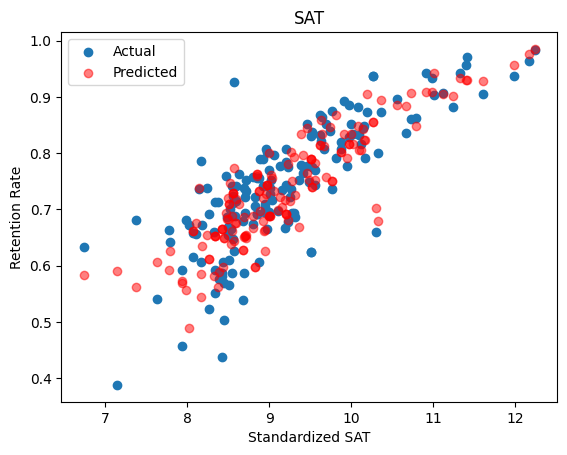

In [9]:
sat_only = rfr(['SAT'])
print(sat_only['mse'])
print(sat_only['r2'])
viz_rfr(sat_only, ['SAT'])

0.005051757978081764
0.6012200831268029


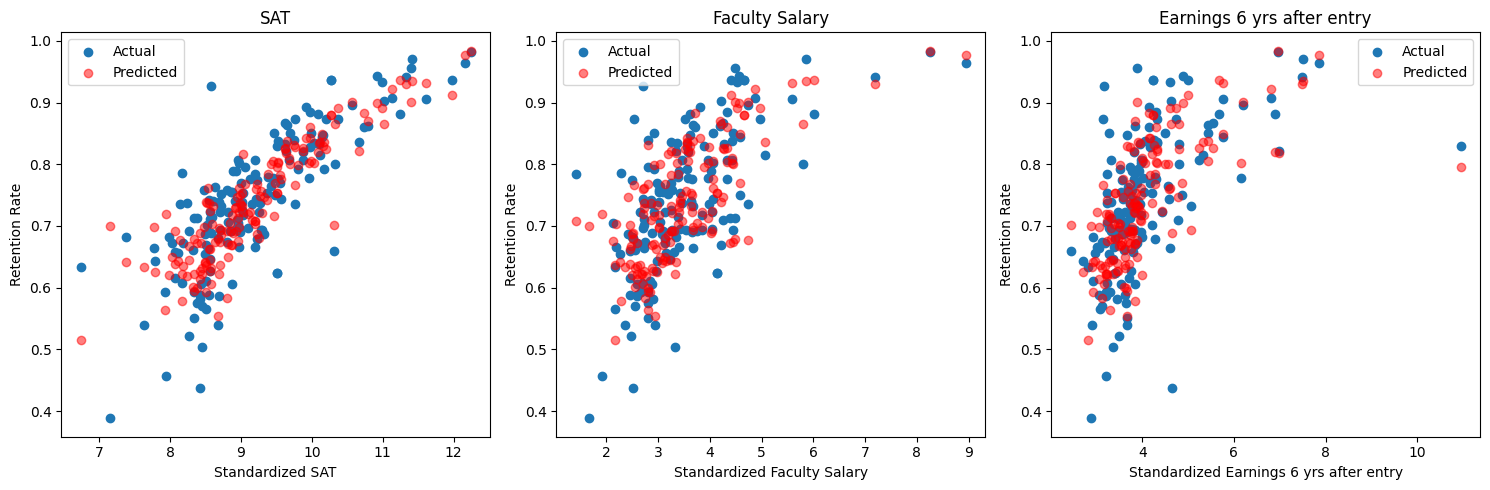

In [10]:
top_3_features = rfr(important_features[:3])
print(top_3_features['mse'])
print(top_3_features['r2'])
viz_rfr(top_3_features, important_features[:4])

In [11]:
# make models with combinations of top features
top_feature = rfr([important_features[0]])
top_2_feats = rfr(important_features[:2])
top_3_feats = rfr(important_features[:3])
top_4_feats = rfr(important_features[:4])
top_5_feats = rfr(important_features[:5])
top_6_feats = rfr(important_features[:6])
top_7_feats = rfr(important_features[:7])
top_8_feats = rfr(important_features[:8])
all_feats = rfr(important_features)

# get each MSE and r2
df_model_stats = pd.DataFrame(columns=['Model Features', 'MSE', 'R^2'])
ls_models = [top_feature, top_2_feats, top_3_feats, top_4_feats, top_5_feats, top_6_feats, top_7_feats, top_8_feats, all_feats]
for m, model_name in zip(ls_models, ['top_feature', 'top_2_feats', 'top_3_feats', 'top_4_feats', 'top_5_feats', 'top_6_feats', 'top_7_feats', 'top_8_feats', 'all_feats']):
    m_stats = {'Model Features': model_name, 'MSE': m['mse'], 'R^2': m['r2']}
    df_model_stats = pd.concat([df_model_stats, pd.DataFrame([m_stats])], ignore_index=True)


In [12]:
# plot figure
fig = go.Figure(data=[
    go.Scatter(x=df_model_stats.index, y=df_model_stats['MSE'], mode='lines', showlegend=False),
    go.Scatter(x=df_model_stats.index, y=df_model_stats['MSE'], mode='markers', marker=dict(size=10), hovertext=df_model_stats['Model Features'], hoverinfo='text', showlegend=False)
])

# title
fig.update_layout(title='MSEs for RFR Models with Different Features')

# show
fig.show()

In [13]:
# plot figure
fig = go.Figure(data=[
    go.Scatter(x=df_model_stats.index, y=df_model_stats['R^2'], mode='lines', showlegend=False),
    go.Scatter(x=df_model_stats.index, y=df_model_stats['R^2'], mode='markers', marker=dict(size=10), hovertext=df_model_stats['Model Features'], hoverinfo='text', showlegend=False)
])

# title
fig.update_layout(title='R^2s for RFR Models with Different Features')

# show
fig.show()